<a href="https://colab.research.google.com/github/nyculescu/kaggle__competitive_data_science_predict_future_sales/blob/master/01_kernel_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

### Input files

* shops.csv- supplemental information about the shops -- `61 entries`
    * shop_name (e.g., "СПб ТК ""Сенная""")
    * shop_id (e.g., 43)

* item_categories.csv  - supplemental information about the items categories -- `85 entries`
    * item_category_name (e.g., Кино - DVD)
    * item_category_id (e.g., 40)

* items.csv - supplemental information about the items/products -- `22.171 entries`
    * item_name (e.g., 1812: 4 СЕРИИ (регион))
    * item_id (e.g., 97)
    * item_category_id (e.g., 40)

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015 -- `2.935.850 entries from which 587.170 entries (20%) should be allotted to the training set`
    * date (e.g., 23.02.2013)
    * date_block_num (e.g., 1)
    * shop_id (e.g., 43)
    * item_id (e.g., 97)
    * item_price (e.g., 149.0)
    * item_cnt_day (e.g., 1.0)

* sample_submission.csv - a sample submission file in the correct format -- `214.201 entries`
    * ID (e.g., 0)
    * item_cnt_month (e.g., 0.5)

* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015 -- `214.201 entries`
    * ID (e.g., 0)
    * shop_id (e.g., 43)
    * item_id (e.g., 97)


### Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

### The objective: what needs to be done?
The task is to forecast the total amount of products sold in every shop for the test set.

! Note that the list of shops and products slightly changes every month.


### Frame this problem
* typical supervised learning task - we have the labeled training examples
* typical regression task - we're asked to predict a value
    * multiple regression problem (value prediction) - the system will use multiple features to make a prediction
    * also univariate regression problem - we're only trying to predict a single value (*total amount of products sold*) in every *shop*
* plain batch learning - we don't have a continuous flow of data coming to the system - the data doesn't need to be adjusted rapidly, and the data is small enoug to fit in memory (`is it so?`)

Select a Performance Measure -- A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.

`todo`

---
# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)


# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# Common imports
import numpy as np
import os
import csv
import pandas as pd
from pandas.plotting import scatter_matrix
import datetime
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "kaggle__competitive_data_science_predict_future_sales"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


# Print the entire number in Python from describe() function, but only for the numeric data
def describe_entire_nrs(datafr):
    desc = datafr.describe() # include='all' will not work
    desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
    desc.iloc[1:] = desc.iloc[1:].applymap('{:.2f}'.format)
    return desc


# Used to generate the test set

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

colab_path = "drive/My Drive/Colab Notebooks/kaggle_competitive_data_science_predict_future_sales"

# -

d:\work\ml\handson-ml2\ml_env\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


---
### Colab

In [23]:
from google.colab import drive
drive.mount('/content/drive')

sales_train = pd.read_csv('%sdatasets/sales_train.csv' % colab_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
### VS Code

In [2]:
sales_train = pd.read_csv(os.path.abspath(os.path.join('input', 'sales_train.csv')))

---
# Get the data & Discover and visualize the data to gain insights

## Analyze the data added

In [0]:
sales_train.head()
sales_train.head(-5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935839,24.10.2015,33,25,7315,399.00,1.0
2935840,31.10.2015,33,25,7409,299.00,1.0
2935841,11.10.2015,33,25,7393,349.00,1.0
2935842,10.10.2015,33,25,7384,749.00,1.0


copy head()'s output into https://www.tablesgenerator.com/markdown_tables#

| idx | date       | date_block_num | shop_id | item_id | item_price | item_cnt_day |
|-----|------------|----------------|---------|---------|------------|--------------|
| 0   | 02.01.2013 | 0              | 59      | 22154   | 999.00     | 1.0          |
| 1   | 03.01.2013 | 0              | 25      | 2552    | 899.00     | 1.0          |
| 2   | 05.01.2013 | 0              | 25      | 2552    | 899.00     | -1.0         |
| 3   | 06.01.2013 | 0              | 25      | 2554    | 1709.05    | 1.0          |
| 4   | 15.01.2013 | 0              | 25      | 2555    | 1099.00    | 1.0          |
|     |            |                |         |         |            |              |

In [0]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [0]:
# see the amount of memory used (in bytes) for each column. 
# It’s useful when building machine learning models which may require a lot memory in training.
sales_train.memory_usage(deep=True)

Index                   128
date              196701883
date_block_num     23486792
shop_id            23486792
item_id            23486792
item_price         23486792
item_cnt_day       23486792
dtype: int64

We can find out what categories exist and how many districts belong to each category by using the value_counts() method, but we know them already (form the description)

In [0]:
# For numeric data, the result’s index will include count, mean, std, min, max as well as lower, 50 and upper percentiles.
# For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. The top is the most common value. The freq is the most common value’s frequency. Timestamps also include the first and last items.

sales_train.describe(include='all')

In [0]:
describe_entire_nrs(sales_train)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,2935849,2935849,2935849,2935849
mean,14.57,33.00,10197.23,890.85,1.24
std,9.42,16.23,6324.30,1729.80,2.62
min,0.00,0.00,0.00,-1.00,-22.00
25%,7.00,22.00,4476.00,249.00,1.00
50%,14.00,31.00,9343.00,399.00,1.00
75%,23.00,47.00,15684.00,999.00,1.00
max,33.00,59.00,22169.00,307980.00,2169.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f13062d1518>,
      dtype=object)

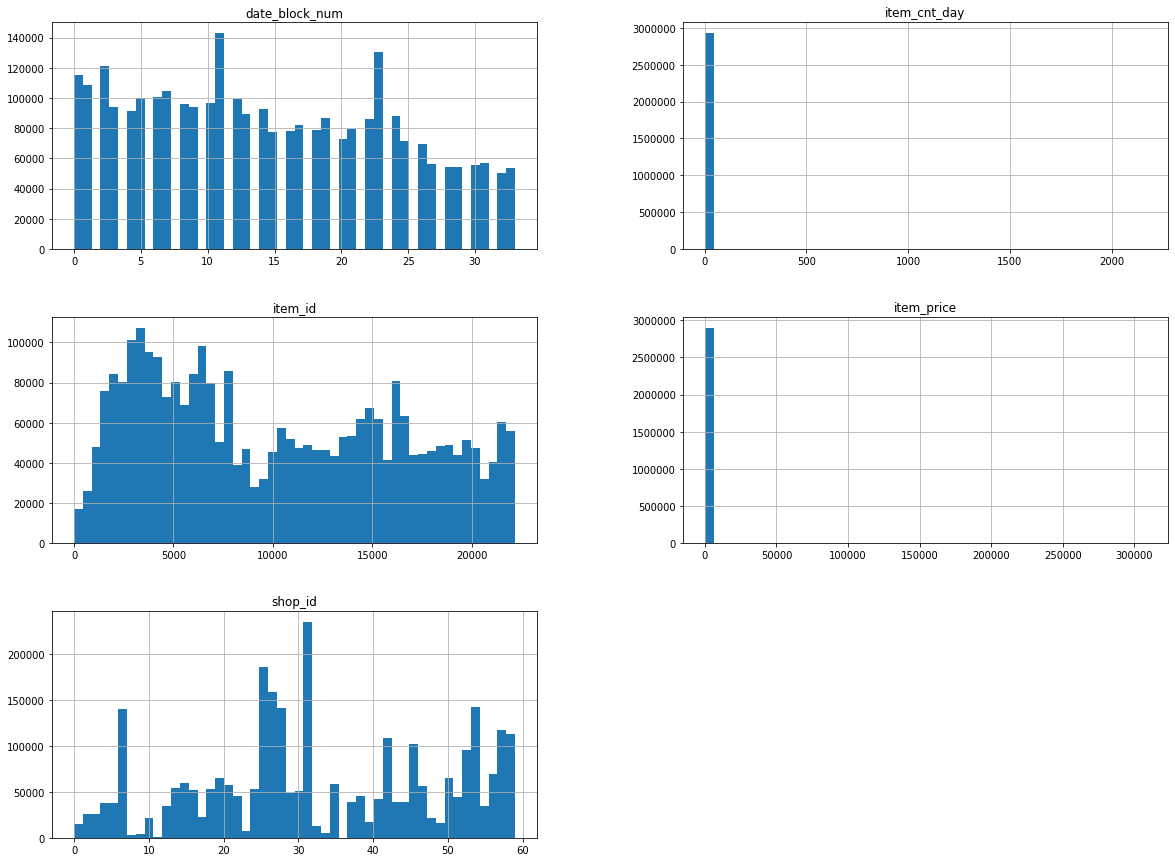

In [0]:
sales_train.hist(bins=50, figsize=(20,15))
# plt.show()

observations on th plotted dataframe:
* date_block_num, item_id, shop_id are capped -- Warning from hands-on book: The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit.
    * date_block_num even capped, doesn't look to be a problem
* These attributes have very different scales
* item_cnt_day and item_price don't express anything


## Looking for Correlations + Experimenting with Attribute Combinations

### First correlations, based on the **sales_train** dataset

In [0]:
corr_matrix = sales_train.corr()
corr_matrix["item_cnt_day"].sort_values(ascending=False)

item_cnt_day      1.000000
item_id           0.016650
item_price        0.011197
date_block_num    0.009402
shop_id          -0.005230
Name: item_cnt_day, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f817bc30dd8>,
      dtype=object)

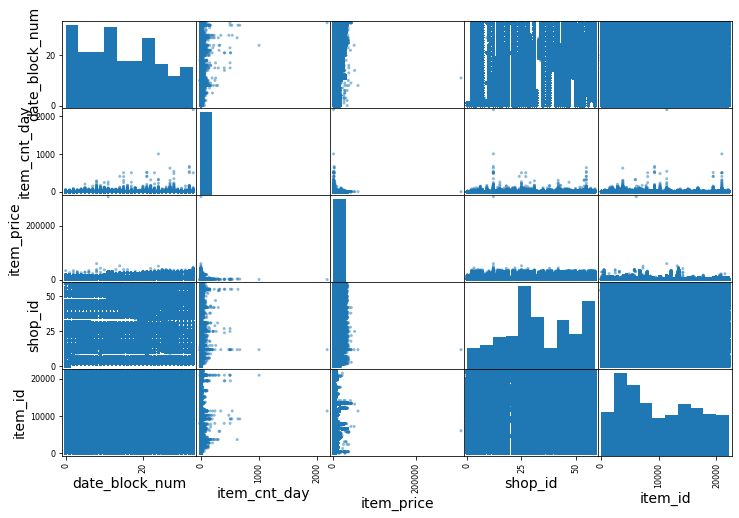

In [0]:
# 'date' attribute will be not considered for the correlations 
#   this represents a sort of a higher resolution of the date_block_num
attributes = ["date_block_num", "item_cnt_day", "item_price", "shop_id", "item_id"]
scatter_matrix(sales_train[attributes], figsize=(12, 8))

Some correlations found:
* date_block_num vs item_cnt_day - more and more items are sold
* date_block_num vs item_price - more and more expensive items are sold
* shop_id vs item_cnt_day - determine which shops sell more to less
* item_id vs item_cnt_day - determine which items are the most sold

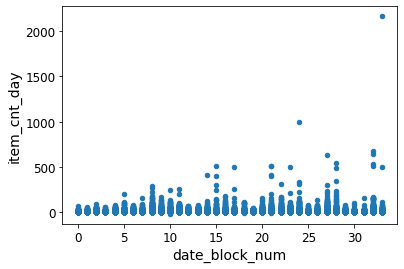

In [0]:
sales_train.plot(kind="scatter", x="date_block_num", y="item_cnt_day")

In [0]:
# Find max value & its index of the shop_id, then print them

# cnt_i = [0] * (sales_train_outl_1shop["shop_id"].max() + 1)
# for i in sales_train_outl_1shop["shop_id"]:
#     cnt_i[i] += 1

# cnt_i_max = np.where(cnt_i == np.amax(cnt_i))[0]
# print("max value: ", cnt_i_max, np.amax(cnt_i))

max value:  [31] 235634


In [0]:
# describe_entire_nrs(sales_train_outl_1shop)

In [0]:
# sales_train_outl_1shop = sales_train_outl_1shop[sales_train_outl_1shop["shop_id"] == cnt_i_max[0]] # drop te rows which doesn't have the shop_id equal to cnt_i_max
# sales_train_outl_mdl = sales_train_outl_1shop.copy()

In [0]:
# sales_train_outl = sales_train[~(sales_train['item_cnt_day'] > 650)] # ignore the outliers
# sales_train_outl = sales_train_outl[~(sales_train_outl['item_cnt_day'] < -1)] # ignore the outliers
# sales_train_outl.plot(kind="scatter", x="date_block_num", y="item_cnt_day")
# sales_train_outl_mdl = sales_train_outl.copy()

### This is not needed due to feature scaling

#### Make a copy of the **sales_train**

In [0]:
sales_train_ = sales_train.copy()

#### The **date** attrb

##### var 1 | delete the **date** attr

In [0]:
sales_train_.drop(["date"], inplace=True, axis=1)

##### var 2 | Convert the **date** attrb into a 'unique number'
> use this

from string pattern dd.mm.yyyy to int pattern yyyymmdd

In [0]:
date = sales_train_[["date"]].values
date_ = [0] * len(date)

# enumerate function allows us to loop over a list and retrieve 
# both the index and the value of each item in the list
for index, d in enumerate(date): # date_.append didn't work properly, so i used the index
  n = int(''.join(c for c in str(d) if c.isdigit()))
  date_[index] = (n%10000)*10000 + (int(n/10000)%100)*100 + int(n/1000000)

sales_train_["date"] = date_

### Add **item_cnt_month** as attr to the **sales_train** dataset

In [0]:
# Attempt of using a new attrb: item_price_med

# sales_train_gb_sh = sales_train.drop(['date_block_num', 'item_id', 'item_cnt_day'], axis = 1).groupby('shop_id').mean() # std seems more reliable
# sales_train_gb_sh.rename(columns={"item_price": "item_price_med"}, inplace=True)

# sales_train_gb_sh.head()

,item_price_med
shop_id,
0,563.444151
1,515.350652
2,1350.638391
3,1036.840634
4,923.994318


In [0]:
sales_train_gb_mth = sales_train.drop(['item_id', 'item_price'], axis = 1).groupby(['shop_id', 'date_block_num']).sum().astype('int')
sales_train_gb_mth.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)

# sales_train_gb_mth.head(5)
sales_train_gb_mth.tail(5)

item_cnt_month
shop_id date_block_num                
59      29                         913
        30                         992
        31                        1214
        32                         914
        33                         790

#### var 1

The method below takes too much time to run 

.loc method seems to be slow 

instead, use the method below this cell


In [0]:
# The following code adds to the attr **item_cnt_month** 

# %%time is used for Colab nb to show the cell's runtime --> CPU times: user 39.4 ms, sys: 668 µs, total: 40.1 ms | Wall time: 40.3 ms
# this overwrites the output

# from IPython.display import clear_output

for row in sales_train_.iterrows():
  # clear_output() # clear the output of the current cell receiving output
  # print(row)

  idx_s = int(sales_train_.loc[sales_train_.index[row[0]], "shop_id"])
  idx_m = int(sales_train_.loc[sales_train_.index[row[0]], "date_block_num"])

  #item_price_med = sales_train_gb_sh["item_price_med"][idx_s]
  #sales_train_.loc[sales_train_.index[row[0]], "item_price_med"] = item_price_med

  item_cnt_month = sales_train_gb_mth["item_cnt_month"]
  sales_train_.loc[sales_train_.index[row[0]], "item_cnt_month"] = int(item_cnt_month[idx_s][idx_m])

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month
0,0,59,22154,999.00,1.0,2017
1,0,25,2552,899.00,1.0,8215
2,0,25,2552,899.00,-1.0,8215
3,0,25,2554,1709.05,1.0,8215
4,0,25,2555,1099.00,1.0,8215


#### var 2

> use this

this method took ~24 min. It was used a list to be filled with the required values, then attached to the main dataframe

start: 2020-02-01 17:16:02.477814 | stop: 2020-02-01 17:40:20.210183

In [0]:
sales_train_c = []

print(datetime.datetime.now())
for row in sales_train_.iterrows():
  item_cnt_month = sales_train_gb_mth["item_cnt_month"]
  item_cnt_month_n = item_cnt_month[row[1][1]][row[1][0]]
  
  sales_train_c.append(int(item_cnt_month_n))

print(datetime.datetime.now())

2020-02-03 09:13:58.560532
2020-02-03 09:39:00.660538


#### Add the **item_cnt_month** list to the main dataframe, then save it locally

In [0]:
sales_train_['item_cnt_month'] = sales_train_c

In [5]:
sales_train_

,Unnamed: 0,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month,date
0,0,0,59,22154,999.00,1.0,2017,20130102
1,1,0,25,2552,899.00,1.0,8215,20130103
2,2,0,25,2552,899.00,-1.0,8215,20130105
3,3,0,25,2554,1709.05,1.0,8215,20130106
4,4,0,25,2555,1099.00,1.0,8215,20130115
...,...,...,...,...,...,...,...,...
2935844,2935844,33,25,7409,299.00,1.0,6247,20151010
2935845,2935845,33,25,7460,299.00,1.0,6247,20151009
2935846,2935846,33,25,7459,349.00,1.0,6247,20151014
2935847,2935847,33,25,7440,299.00,1.0,6247,20151022


In [0]:
# Colab - save the reshaped dataset
sales_train_.to_csv(r"%sdatasets/sales_train_reshaped.csv" % colab_path)

In [0]:
# Colab - get the reshaped dataset from drive
sales_train_ = pd.read_csv('%sdatasets/sales_train_reshaped.csv' % colab_path)

In [0]:
# VS Code - save the reshaped dataset
sales_train_.to_csv(r"input/sales_train_reshaped.csv")

In [12]:
# VS Code - get the reshaped dataset from local drive
sales_train_ = pd.read_csv(os.path.abspath(os.path.join('input', 'sales_train_reshaped.csv')))

In [13]:
sales_train_.drop('Unnamed: 0', axis=1, inplace=True)
sales_train_

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month,date
0,0,59,22154,999.00,1.0,2017,20130102
1,0,25,2552,899.00,1.0,8215,20130103
2,0,25,2552,899.00,-1.0,8215,20130105
3,0,25,2554,1709.05,1.0,8215,20130106
4,0,25,2555,1099.00,1.0,8215,20130115
...,...,...,...,...,...,...,...
2935844,33,25,7409,299.00,1.0,6247,20151010
2935845,33,25,7460,299.00,1.0,6247,20151009
2935846,33,25,7459,349.00,1.0,6247,20151014
2935847,33,25,7440,299.00,1.0,6247,20151022


#### Check for new correlations

In [0]:
corr_matrix = sales_train_.corr()
corr_matrix["item_cnt_month"].sort_values(ascending=False)

item_cnt_month    1.000000
shop_id           0.072295
item_id           0.061264
item_cnt_day      0.024699
item_price       -0.036215
date_block_num   -0.184236
date             -0.219112
Name: item_cnt_month, dtype: float64

* **item_cnt_month** is the most correlated with **date**, but we need to estimate per month, not per day 

* **item_cnt_month** is then the most correlated with **date_block_num**, which is the same as the previous steps

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85ff1ae668>,
      dtype=object)

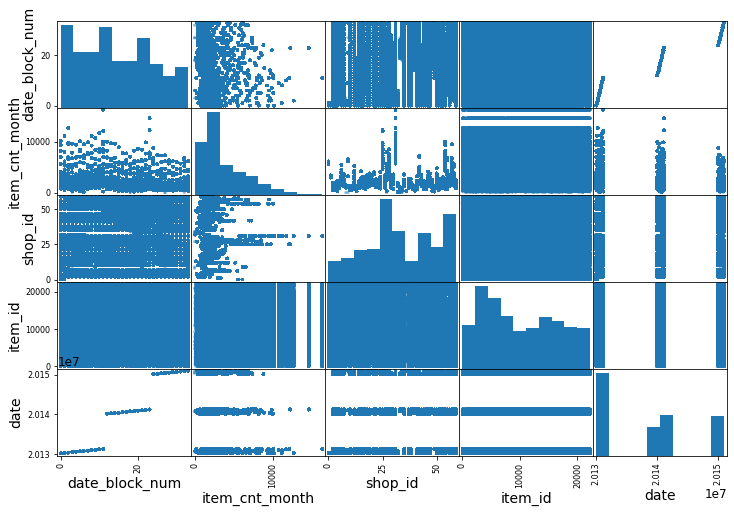

In [0]:
attributes = ["date_block_num", "item_cnt_month", "shop_id", "item_id", "date"]
scatter_matrix(sales_train_[attributes], figsize=(12, 8))

Interesting correlations from the plot:
* **shop_id** - **item_cnt_month**
* **date_block_num** - **item_cnt_month**

#### Plot a complex map

No handles with labels found to put in legend.


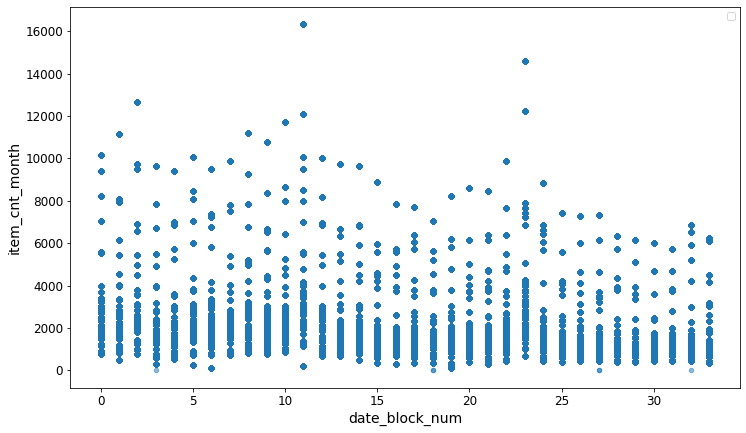

In [10]:
sales_train_.plot(kind="scatter", 
                  x="date_block_num", 
                  y="item_cnt_month",
                  # s=sales_train_["shop_id"], # the size of the circles
                  # label="shop_id",
                  # c="item_price_med", cmap=plt.get_cmap("jet"), colorbar=True, # the color of the circles
                  figsize=(12,7),
                  alpha=0.5, sharex=False
                  )
plt.legend()

No handles with labels found to put in legend.


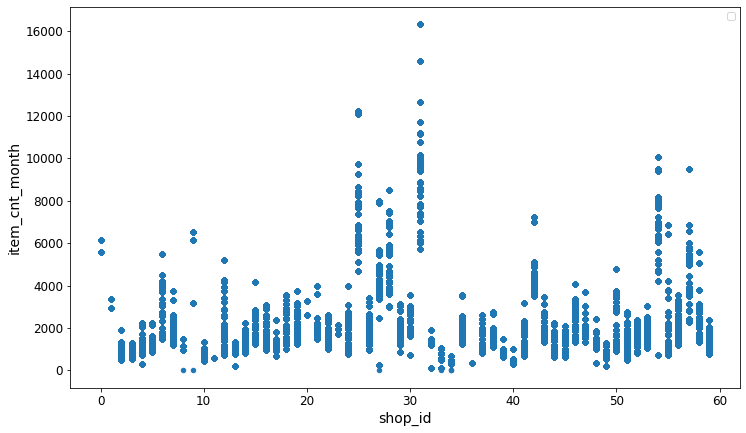

In [11]:
sales_train_.plot(kind="scatter", 
                  x="shop_id", 
                  y="item_cnt_month",
                  figsize=(12,7),
                  sharex=False
                  )
plt.legend()

## Compute a test set

### var 1

Compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

In [14]:
sales_train_with_id = sales_train.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(sales_train_with_id, 0.2, "index")

### var 2

> &uarr; use this


In [15]:
# this method is used because we'll have only one epoch of training
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(sales_train_, train_size=0.8, shuffle=False) # 80% of data will be chosen for train_set

### copy the train_set

In [16]:
sales_train_ts = train_set.copy()

---
# Prepare the data for Machine Learning algorithms

**>> ?**

I didn't understand exactly what the negative values repesent, but I suppose that:

* item_cnt_day -- items stolen or not added to the inventory
* item_price -- items stolen, sold under the real price or offered as bonus



In [0]:
# cleanup the rows which have the item_cnt_day and item_price with negative values

# sales_train_ts = sales_train_ts[~(sales_train_ts['item_cnt_day'] < 0)]
# sales_train_ts = sales_train_ts[~(sales_train_ts['item_price'] < 0)]

In [17]:
# The predictor will be the feature item_cnt_month

sales_train_ts_lb = sales_train_ts['item_cnt_month'].copy()
sales_train_ts.drop('item_cnt_month', axis=1, inplace=True)

### Preprocess the categorical input features
* item_id
* shop_id
* <strike>date</strike> [---](#eacv2)

In [18]:
from sklearn.preprocessing import OneHotEncoder

item_cat_1hot = OneHotEncoder().fit_transform(sales_train_ts[["item_id"]])
shop_cat_1hot = OneHotEncoder().fit_transform(sales_train_ts[["shop_id"]])

attr_to_be_dropped = {
    "item_id",
    "shop_id"
    }
sales_train_num = sales_train_ts.drop(attr_to_be_dropped, axis=1)

In [19]:
sales_train_num

,date_block_num,item_price,item_cnt_day,date
0,0,999.00,1.0,20130102
1,0,899.00,1.0,20130103
2,0,899.00,-1.0,20130105
3,0,1709.05,1.0,20130106
4,0,1099.00,1.0,20130115
...,...,...,...,...
2348674,24,1083.25,1.0,20150106
2348675,24,1399.00,1.0,20150118
2348676,24,1199.00,1.0,20150115
2348677,24,149.00,1.0,20150113


### Build a pipeline for preprocessing the numerical attributes

#### Now let's build a pipeline for preprocessing the numerical attributes:

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([ # a small pipeline for the numerical attributes
        ('imputer', SimpleImputer(strategy="median")),
        # ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

sales_train_num_tr = num_pipeline.fit_transform(sales_train_num)

In version 0.20, Scikit-Learn introduced the ColumnTransformer to have a single transformer able to handle all columns -- to avoid handle the categorical columns and the numerical columns separately


In [21]:
from sklearn.compose import ColumnTransformer

num_attribs = list(sales_train_num)
# item_attribs = [["item_id"], ["shop_id"]]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        # (["itm", "shp"], OneHotEncoder(), item_attribs)
        ("itm", OneHotEncoder(), ["item_id"]),
        ("shp", OneHotEncoder(), ["shop_id"]),
    ])

sales_train_ts_prep = full_pipeline.fit_transform(sales_train_ts)

Here is how this works: first we import the ColumnTransformer class, next we get the list of numerical column names and the list of categorical column names, and we construct a ColumnTransformer. The constructor requires a list of tuples, where each tuple contains a name, a transformer and a list of names (or indices) of columns that the transformer should be applied to. 

In this example, we specify that the numerical columns should be transformed using the num_pipeline that we defined earlier, and the categorical columns should be transformed using a OneHotEncoder. 

Finally, we apply this ColumnTransformer to the **sales_train** data: it applies each transformer to the appropriate columns and concatenates the outputs along the second axis (the transformers must return the same number of rows).

---
# The model

In [0]:
### this is a draft

# lin1 = sklearn.linear_model.LinearRegression()

# Xsample1 = np.c_[sales_train_mdl["date_block_num"]]
# ysample1 = np.c_[sales_train_mdl["item_cnt_day"]]
# lin1.fit(Xsample1, ysample1)
# t0 = lin1.intercept_[0]
# t1 = lin1.coef_[0][0]

# sales_train_mdl.plot(kind='scatter', x="date_block_num", y='item_cnt_day')
# y = np.linspace(sales_train_mdl["date_block_num"].min(), sales_train_mdl["date_block_num"].max())
# # plt.plot(y, t0 + t1*y, "r+", alpha=1) # the trend is not visible if it's plotted here

In [0]:
### this is a draft

# plt.plot(y, t0 + t1*y, "r+") # this describes a linear trend

## Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression

print(datetime.datetime.now())
lin_reg = LinearRegression()
lin_reg.fit(sales_train_ts_prep, sales_train_ts_lb)
print(datetime.datetime.now())

2020-02-05 20:13:33.653041
2020-02-05 20:15:37.629983


In [37]:
# Save the current model in Drive

joblib.dump(lin_reg, "%smodels/lin_reg.pkl" % colab_path)

['drive/My Drive/Colab Notebooks/kaggle_competitive_data_science_predict_future_sales/models/lin_reg.pkl']

In [15]:
# let's try the full preprocessing pipeline on a few training instances
some_data = sales_train_ts.iloc[:5]
some_labels = sales_train_ts_lb.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [1913.19634677 7681.00405623 7665.18102295 8214.36870995 7947.97978686]


In [44]:
print("Labels:", list(some_labels))

Labels: [2017, 8215, 8215, 8215, 8215]


Compare against the actual values:

In [16]:
sales_train_predictions = lin_reg.predict(sales_train_ts_prep)
lin_mse = mean_squared_error(sales_train_ts_lb, sales_train_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

945.6653657767256

In [41]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(sales_train_ts_lb, sales_train_predictions)
lin_mae

635.259837605684

The model underfits the training data -- it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough

## Decision Tree Regressor

In [38]:
from sklearn.tree import DecisionTreeRegressor

print(datetime.datetime.now())
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(sales_train_ts_prep, sales_train_ts_lb)
print(datetime.datetime.now())

2020-02-05 14:47:23.326804
2020-02-05 14:48:13.399870


In [41]:
sales_train_predictions = tree_reg.predict(sales_train_ts_prep)
tree_mse = mean_squared_error(sales_train_ts_lb, sales_train_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

the result is 0.0 --> the model is overfitting the training set badly

In [42]:
# Save the current model in Drive

joblib.dump(tree_reg, "%smodels/tree_reg.pkl" % colab_path)

['drive/My Drive/Colab Notebooks/kaggle_competitive_data_science_predict_future_sales/models/tree_reg.pkl']

## Evaluation using **Cross-Validation** for _Linear Regression_ and _Decision Tree Regressor_ models

Little things for Cross-Validation

There are some caveats in the train/test split method (80%-20%). In order to avoid this, we can perform something called **cross validation**. It’s very similar to train/test split, but it’s applied to more subsets. Meaning, we split our data into k subsets, and train on k-1 one of those subset. What we do is to hold the last subset for test. We’re able to do it for each of the subsets.

![](https://miro.medium.com/max/1185/1*4G__SV580CxFj78o9yUXuQ.png)

A great alternative* to evaluate the **Decision Tree model** is to use Scikit-Learn’s cross-validation feature. The following code performs K-fold cross-validation: it randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

`*One way to evaluate the Decision Tree model would be to use the train_test_split function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. It’s a bit of work...`

Scikit-Learn’s cross-validation features expect a *utility function* (greater is better)

In [0]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, # Decision Tree Regression
                         sales_train_ts_prep, sales_train_ts_lb,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [46]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [1154.18216135  991.97927223  578.12261944  468.93434823 1493.46599155
 1829.94513933  460.20095367  462.74438862  820.08943456 2074.20357007]
Mean: 1033.38678790521
Standard deviation: 563.1452999529927


In [47]:
lin_scores = cross_val_score(lin_reg, # Linear Regression
                             sales_train_ts_prep, sales_train_ts_lb,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [1002.85700693  928.10915351  709.08649255  573.00833524 1154.24329741
 1531.48986869  690.47800705 1022.91480785 1220.46128013 1965.2870501 ]
Mean: 1079.7935299455162
Standard deviation: 398.9288941224045


## Random Forest Regressor 

[Understanding Random Forest](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) -- How the Algorithm Works and Why it Is So Effective

In [11]:
from sklearn.ensemble import RandomForestRegressor

print(datetime.datetime.now())
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(sales_train_ts_prep, sales_train_ts_lb)
print(datetime.datetime.now())

2020-02-05 19:01:57.978695


KeyboardInterrupt: 

>> 
&uarr; This gets stuck or takes too long to run

In [0]:
sales_train_predictions = forest_reg.predict(sales_train_ts_prep)
forest_mse = mean_squared_error(sales_train_ts_lb, sales_train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

In [0]:
# Save the current model in Drive

joblib.dump(forest_reg, "%smodels/forest_reg.pkl" % colab_path)

## Evaluation using Cross-Validation for _Random Forest Regressor_ model

Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions.

In [0]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, # Random Forest Regressor
                                sales_train_ts_prep, sales_train_ts_lb,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

In [0]:
scores = cross_val_score(lin_reg, sales_train_ts_prep, sales_train_ts_lb, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

# Fine tune the model

## Fine-tune methods

### Grid Search (var 1)

The grid search approach is fine when you are exploring relatively few combinations

The model chosen is **RandomForestRegressor**

To avoid fiddling with the hyperparameters manually, until finding a great combination of hyperparameter values, use **Scikit-Learn’s GridSearchCV** to search them for our purpose. All we need to do is tell it which hyperparameters we want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation.

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(sales_train_ts_prep, sales_train_ts_lb)

In [0]:
# The best hyperparameter combination found:

grid_search.best_params_

In [0]:
# get the best estimator directly

grid_search.best_estimator_

Let's look at the score of each hyperparameter combination tested during the grid search:

In [0]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params) # evaluation scores

In [0]:
pd.DataFrame(grid_search.cv_results_)

### Randomized Search (var 2)

when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(sales_train_ts_prep, sales_train_ts_lb)

In [0]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

### Ensemble Methods

`next time...`

## Analyze the Best Models and Their Errors

`next time...`

In [0]:
# feature_importances = grid_search.best_estimator_.feature_importances_
# feature_importances

In [0]:
# With this information, I may want to try dropping some of the less useful features

# extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
# #cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
# cat_encoder = full_pipeline.named_transformers_["cat"]
# cat_one_hot_attribs = list(cat_encoder.categories_[0])
# attributes = num_attribs + extra_attribs + cat_one_hot_attribs
# sorted(zip(feature_importances, attributes), reverse=True)

You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or, on the contrary, getting rid of uninformative ones, cleaning up outliers, etc.)

## Evaluate the System on the Test Set

In [23]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("item_cnt_month", axis=1)
y_test = test_set["item_cnt_month"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

NameError: name 'grid_search' is not defined

In [0]:
final_rmse

In [0]:
# We can compute a 95% confidence interval for the test RMSE:

from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

> (!) </br>The performance will usually be slightly worse than what you measured using cross-validation if you did a lot of hyperparameter tuning (because your system ends up fine-tuned to perform well on the validation data, and will likely not perform as well on unknown datasets) -- you must **resist the temptation to tweak the hyperparameters** to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.

In [0]:
# We could compute the interval manually like this:

# m = len(squared_errors)
# mean = squared_errors.mean()
# tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
# tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
# np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

In [0]:
# Alternatively, we could use a z-scores rather than t-scores:

# zscore = stats.norm.ppf((1 + confidence) / 2)
# zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
# np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

---

---

# Misc stuff

## The other data from the CSVs

In [0]:
item_categories = pd.read_csv(os.path.abspath(os.path.join('input', 'item_categories.csv')))
items = pd.read_csv(os.path.abspath(os.path.join('input', 'items.csv')))
sample_submission = pd.read_csv(os.path.abspath(os.path.join('input', 'sample_submission.csv')))
shops = pd.read_csv(os.path.abspath(os.path.join('input', 'shops.csv')))
test = pd.read_csv(os.path.abspath(os.path.join('input', 'test.csv')))

In [0]:
item_categories.info()
item_categories.describe(include='all')

In [0]:
items.info()
items.describe(include='all')

In [0]:
sample_submission.info()
sample_submission.describe(include='all')

In [0]:
shops.info()
shops.describe(include='all')

In [0]:
test.info()
test.describe(include='all')

## A full pipeline with both preparation and prediction

In [0]:
from sklearn.linear_model import LinearRegression

# lin_reg = LinearRegression()
# lin_reg.fit(sales_train_ts_prep, sales_train_ts_lb)

In [0]:
some_data = sales_train_ts_prep.iloc[:5]
# some_labels = sales_train_ts_lb.iloc[:5]
# some_data_prepared = full_pipeline.transform(some_data)

# print("Predictions:", lin_reg.predict(some_data_prepared))

In [0]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(sales_train_ts_prep, sales_train_ts_lb)
full_pipeline_with_predictor.predict(some_data)

## Example SciPy distributions for RandomizedSearchCV

In [0]:
from scipy.stats import geom, expon

geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()